# Understanding Gradient Based Adversarial Attacks

Adversarial perturbations are small changes to an machine learning model's input with the goal of pushing that input over the model's decision boundary. The jabobian-based dataset augmentation method is a way of training a substitute model to learn the decision boundaries of a black-box machine learning model. Visualizing decision boundaries and understanding concepts from gradient-based adversarial attacks can be challenging in high dimensional spaces. This notebook will explore the works from the papers posted below with an example in two-dimensions to show how decision boundaries can be learned and crossed 

* Explaining and harnessing Adversarial Examples - https://arxiv.org/pdf/1412.6572.pdf
* Practical Black-Box Attacks against Machine Learning - https://arxiv.org/pdf/1602.02697.pdf

We'll start with a simple classification example with a subset of the Iris dataset - (inspired from: 
https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac)

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from matplotlib.lines import Line2D

sns.set(style="white")
figure_size = [11,7.5]

In [2]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

In [3]:
colors = np.asarray(['r']*len(y))
colors[y==1] = 'b'

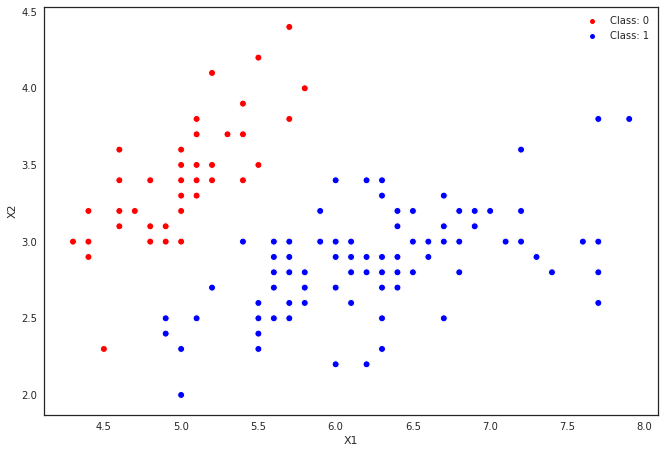

In [4]:
f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
ax.scatter(X[:,0], X[::, 1], c=colors, edgecolor="white", linewidth=1)
plt.xlabel("X1"),plt.ylabel("X2")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class: 0',
                          markerfacecolor='r', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Class: 1',
                          markerfacecolor='b', markersize=5)]
ax.legend(handles=legend_elements)

Above, we have a scatter plot showing two classes in the sample dataset. We will use a logistic regression as our classifier and can use its coefficients to draw its decision boundary and create a probability distribution of the class of a data point given the X1 & X2 variables.

We'll fit a logistic regression to X values by changing Theta
![sigmoid](photos/blg_0.PNG)
![sigmoid](photos/blg_1.PNG)

In [5]:
clf = LogisticRegression().fit(X, y)
w = clf.coef_[0]
a = -w[0] / w[1]
xx_mod = np.linspace(3.5, 8.4)
yy_mod = a * xx_mod - (clf.intercept_[0]) / w[1]

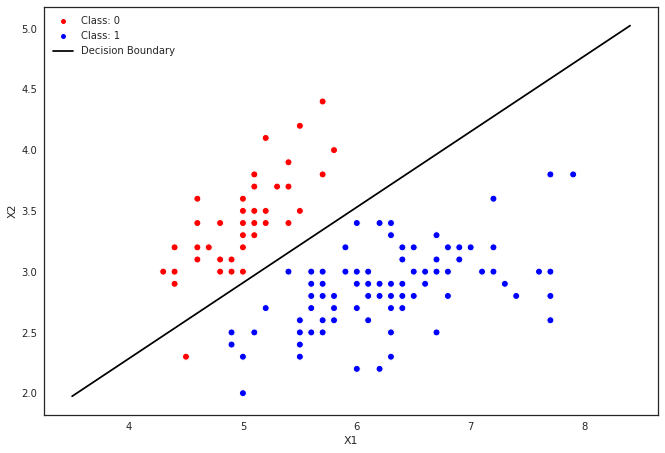

In [6]:
f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
ax.scatter(X[:,0], X[:, 1], c=colors,edgecolor="white", linewidth=1)
plt.xlabel("X1"),plt.ylabel("X2")
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class: 0',
                          markerfacecolor='r', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Class: 1',
                          markerfacecolor='b', markersize=5),
                   Line2D([0], [0], marker='None', color='black', label='Decision Boundary',
                          markerfacecolor='black', markersize=5)]
ax.legend(handles=legend_elements)
ax.plot(xx_mod, yy_mod, 'k-')

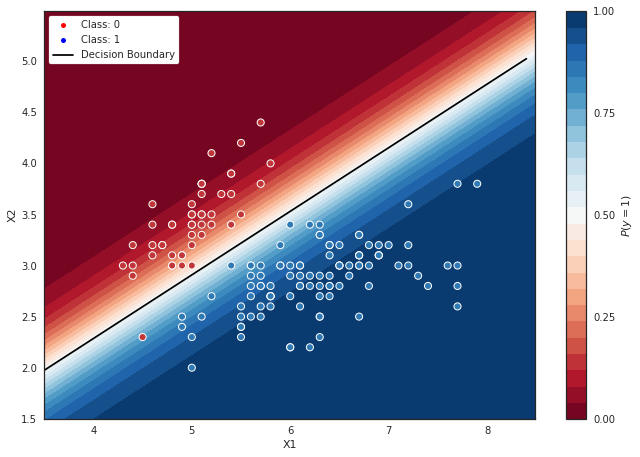

In [7]:
xx, yy = np.mgrid[3.5:8.5:.01, 1.5:5.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:,0], X[::, 1], c=y, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class: 0',
                          markerfacecolor='r', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Class: 1',
                          markerfacecolor='b', markersize=5),
                   Line2D([0], [0], marker='None', color='black', label='Decision Boundary',
                          markerfacecolor='black', markersize=5)]
legend = ax.legend(handles=legend_elements, frameon=True, framealpha=1)
legend.get_frame().set_facecolor('white')
plt.xlabel("X1"),plt.ylabel("X2")
ax.plot(xx_mod, yy_mod, 'k-')

When we train our machine learning models, we're defining a loss function that we then aim to minimize
![sigmoid](photos/blg_2.PNG)

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def prediction(h_arr, thresh):
    return np.asarray(list(map(lambda h: 1 if h>=thresh else 0, h_arr)))
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [9]:
theta = clf.coef_
z = np.dot(X, theta[0])
h = sigmoid(z)
print("This is our model's training loss:", loss(h, y))

This is our model's training loss: 0.14036645522503513


To update the values of theta, we take the partial derivative of our loss function with respect to (w.r.t) theta. The partial derivative tells us how to change the values of theta to change the loss
![sigmoid](photos/blg_3.PNG)

In [10]:
gradient_wrt_theta = np.dot(X.T, (h - y)) / y.shape[0]
print("Grads w.r.t. Theta",gradient_wrt_theta)

Grads w.r.t. Theta [0.31118421 0.22137146]


With gradient-based adversarial attacks, we want to use the gradients to determine how to change ***X*** such that the loss increases (or decreases with a targeted attack)
![sigmoid](photos/blg_4.PNG)

In [11]:
gradient_wrt_X = np.dot(np.expand_dims((h-y),1),theta)/y.shape[0]
print("Grads w.r.t. X",gradient_wrt_X[0])
gradient_magnitudes = np.expand_dims(np.asarray(list(map(lambda x: np.linalg.norm(x), gradient_wrt_X))),1)
print("Gradient magnitude",gradient_magnitudes[0])
grads_norm = gradient_wrt_X/gradient_magnitudes
print("Normalized gradient vector",grads_norm[0])

Grads w.r.t. X [ 0.00354426 -0.00569474]
Gradient magnitude [0.00670759]
Normalized gradient vector [ 0.52839521 -0.84899853]


*** Creating the adversarial perturbation ***

To create the adversarial X values, we use the normalized gradient vectors with a step size of epsilon to attempt to push the X value over the decision boundary

In [12]:
epsilon = 0.5
X_advs = X+grads_norm*epsilon

(Text(0.5,0,'X1'), Text(0,0.5,'X2'))

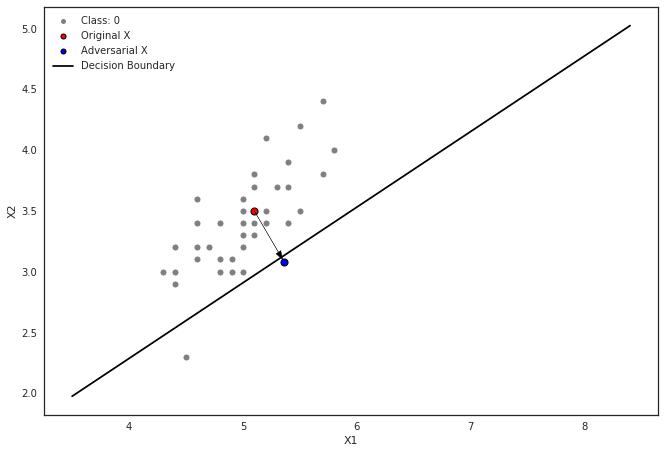

In [25]:
f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
colors = np.asarray(['gray']*len(y))
ax.scatter(X[:50,0], X[:50, 1], c='grey', s=50,#y[:1], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
ax.scatter(X[:1,0], X[:1, 1], c='red', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="black", linewidth=1)
ax.scatter(X_advs[:1,0], X_advs[:1, 1], c='blue', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="black", linewidth=1)
plt.arrow(X[0,0], X[0,1], (X_advs[0,0]-X[0,0])*0.8, (X_advs[0,1]-X[0,1])*0.8,
         head_width = 0.05, color="black")
ax.plot(xx_mod, yy_mod, 'k-')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class: 0',
                          markerfacecolor='grey', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Original X', markeredgecolor = 'black',
                          markeredgewidth=1, markerfacecolor='red', markersize=5),
                   Line2D([0], [0], marker='o', color='w', label='Adversarial X', markeredgecolor = 'black',
                          markeredgewidth=1, markerfacecolor='blue', markersize=5),
                   Line2D([0], [0], marker='None', color='black', label='Decision Boundary',
                          markerfacecolor='black', markersize=5)]
ax.legend(handles= legend_elements)
plt.xlabel("X1"),plt.ylabel("X2")

From the figure above, we're able to see that we chose the correct step size (epsilon) to cross our victim model's decision boundary. In the figure below, we can see that this step size works for several points in our dataset.

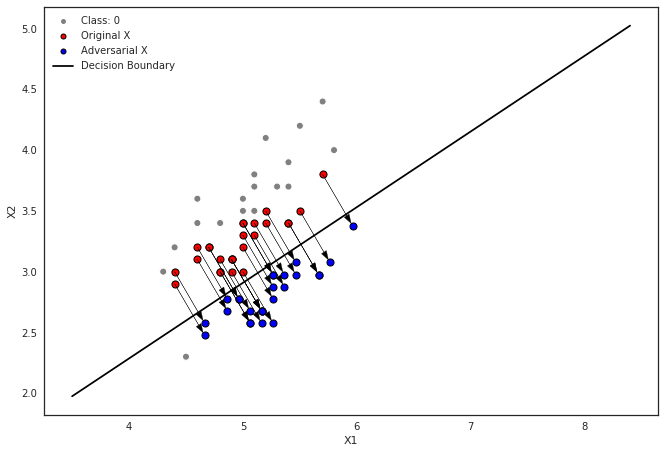

In [24]:
sample = np.asarray([1,2,3,7,8,9,12,18,20,23,25,26,27,28,
                     29,30,31,34,35,36,37,38,39,45,47,49])

f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
colors = np.asarray(['gray']*len(y))
ax.scatter(X[:50,0], X[:50, 1], c=colors[:50], s=50,#y[:1], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.scatter(X[sample,0], X[sample, 1], c='red', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="black", linewidth=1)

ax.scatter(X_advs[sample,0], X_advs[sample, 1], c='blue', s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="black", linewidth=1)

for arr in sample:
    plt.arrow(X[arr,0], X[arr,1], 
          (X_advs[arr,0]-X[arr,0])*0.80, 
          (X_advs[arr,1]-X[arr,1])*0.80,
          head_width = 0.05, color="black")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class: 0',
                      markerfacecolor='grey', markersize=5),
               Line2D([0], [0], marker='o', color='w', markeredgecolor = 'black', label='Original X',
                      markeredgewidth = 1, markerfacecolor='red', markersize=5),
               Line2D([0], [0], marker='o', color='w', markeredgecolor = 'black', label='Adversarial X',
                      markeredgewidth = 1, markerfacecolor='blue', markersize=5),
               Line2D([0], [0], marker='None', color='black', label='Decision Boundary',
                      markerfacecolor='black', markersize=5)]
ax.legend(handles= legend_elements)
plt.xlabel("X1"),plt.ylabel("X2")
ax.plot(xx_mod, yy_mod, 'k-')

*** Checking predictions ***

We can see that crossing the decision boundary indeed changed our model's predictions

In [15]:
print("victim model predictions", clf.predict(X_advs[sample]))
print("original labels:        ", y[sample])

victim model predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
original labels:         [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# Black-Box Jacobian Augmentation

This is cool and all... but it assumes that we know the decision boundary of our victim model. What do we do in situations where we are facing a black box victim which returns only the class values?

In [16]:
def calculate_gradients(model, X_train, y_train):
    theta = model.coef_
    h = sigmoid(np.dot(X_train, theta[0]))
    gradient_wrt_X = np.dot(np.expand_dims((h-y_train),1),theta)/y_train.shape[0]
    gradient_magnitudes = np.expand_dims(np.asarray(list(map(lambda x: np.linalg.norm(x), gradient_wrt_X))),1)
    grads_norm = gradient_wrt_X/gradient_magnitudes
    return grads_norm

In [17]:
def decision_boundary(model, X_range):
    w = model.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(X_range[0], X_range[1])
    yy = a * xx - (model.intercept_[0]) / w[1]
    return (xx, yy)

In [169]:
class Substitute:
    def __init__(self, victim, X_init, X_range):
        self.victim = victim
        self.X = X_init
        self.model = LogisticRegression()
        self.X_range = X_range
    
    def train(self, augment_count, lambda_):
        for augment_step in range(augment_count):
            self.aug_s = augment_step
            self.y = self.victim.predict(self.X) #X
            self.model = LogisticRegression()
            self.model.fit(self.X, self.y)
            if(augment_step==augment_count-1):
                break
            grads = calculate_gradients(self.model, self.X, self.y) #X
            self.X_aug = self.X + lambda_*grads #
            #print(grads)
            self.prev_model = self.model
            self.plot_train_step()
            
            self.X_prev = self.X
            new_X_set = np.concatenate((self.X, self.X_aug), axis=0)
            np.random.shuffle(new_X_set)
            self.X = new_X_set
            #self.last_aug = self.X_aug
            
    def plot_train_step(self):
        X_values = np.concatenate((self.X[:,0],np.asarray(self.X_range)))
        X_range = (min(X_values)-0.5,max(X_values)+0.10)
        (xx_mod, yy_mod) = decision_boundary(self.victim, X_range)
        #(xx_sub_prev, yy_sub_prev) = decision_boundary(self.prev_model, X_range)
        (xx_sub, yy_sub) = decision_boundary(self.model, X_range)
        y_values = np.concatenate((yy_mod, self.X[:,1]))
        y_range = (min(y_values)-0.5,max(y_values)+0.5)
        
        #legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label='Class: 0',
                          markerfacecolor='r', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label='Class: 1',
                                  markerfacecolor='b', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label='Augmented Point', markeredgecolor="black",
                                  markeredgewidth=1, markerfacecolor='grey', markersize=5),
                           Line2D([0], [0], marker='None', color='black', label='Victim Decision Boundary',
                                  markerfacecolor='black', markersize=5),
                           Line2D([0], [0], marker='None', ls='dotted', color='black', label='Substitute Decision Boundary',
                                  markerfacecolor='blue', markersize=5)]
        
        ###Train###
        f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
        #plot true points
        ax.scatter(self.X[:,0], self.X[:, 1], c=self.y, s=50,#y[:1], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
        plt.xlim((X_range)),plt.ylim((y_range)),plt.xlabel("X1"),plt.ylabel("X2")
        ax.plot(xx_mod, yy_mod, 'k-', lw = 2)
        ax.plot(xx_sub, yy_sub, ':')
        f.suptitle('Train', fontsize=20)
        legend = ax.legend(handles=legend_elements, frameon=True, framealpha=1, loc=2)
        legend.get_frame().set_facecolor('white')
        f.savefig('photos/ja_train_'+str(self.aug_s)+".png")
        plt.figure()
        
        ###Augment###
        f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
        #plot model predicted points
        ax.scatter(self.X[:,0], self.X[:, 1], c=self.prev_model.predict(self.X), s=50,#y[:1], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
        ax.scatter(self.X_aug[:,0], self.X_aug[:, 1], c='grey', s=50,#y[:1], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="black", linewidth=1)
        for arr in range(self.X_aug.shape[0]):
            plt.arrow(self.X[arr,0], self.X[arr,1], #self.X_prev[arr,0], self.X_prev[arr,1], 
                  #(self.X_aug[arr,0]-self.X_prev[arr,0])*0.65, 
                  #(self.X_aug[arr,1]-self.X_prev[arr,1])*0.65,
                  (self.X_aug[arr,0]-self.X[arr,0])*0.65,
                  (self.X_aug[arr,1]-self.X[arr,1])*0.65,
                  head_width = 0.05, color="black")
        plt.xlim((X_range)), plt.ylim((y_range)), plt.xlabel("X1"), plt.ylabel("X2")
        #ax.plot(xx_sub_prev, yy_sub_prev, ':')
        ax.plot(xx_mod, yy_mod, 'k-', lw = 2)
        ax.plot(xx_sub, yy_sub, ':')
        f.suptitle('Augment', fontsize=20)
        legend = ax.legend(handles=legend_elements, frameon=True, framealpha=1, loc=2)
        legend.get_frame().set_facecolor('white')
        f.savefig('photos/ja_augment_'+str(self.aug_s)+".png")
        plt.figure()
        
        ###classify###
        
        f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
        ax.scatter(self.X[:,0], self.X[:, 1], c=self.victim.predict(self.X), s=50,#y[:1], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
        ax.scatter(self.X_aug[:,0], self.X_aug[:, 1], c=self.victim.predict(self.X_aug), s=50,#y[:1], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="black", linewidth=1)
        plt.xlim((X_range)), plt.ylim((y_range)), plt.xlabel("X1"), plt.ylabel("X2")
        ax.plot(xx_sub, yy_sub, ':')        
        ax.plot(xx_mod, yy_mod, 'k-', lw = 2)
        f.suptitle('Label', fontsize=20)
        legend = ax.legend(handles=legend_elements, frameon=True, framealpha=1, loc=2)
        legend.get_frame().set_facecolor('white')
        f.savefig('photos/ja_label'+str(self.aug_s)+".png")
        plt.figure()

In [178]:
X_inds = np.asarray(range(X.shape[0]))
#X_sample_inds = np.random.choice(X_inds, size=15, replace=False)
#print(X_sample_inds)
balanced_sample = np.concatenate((np.random.choice(X_inds[:50], size=3, replace=False),
                                  np.random.choice(X_inds[50:], size=6, replace=False)))
print(balanced_sample)
#sub_model = Substitute(clf, X[X_sample_inds,] , X_range=(4,6))
sub_model = Substitute(clf, X[balanced_sample,] , X_range=(4,6))

[ 27  46  17 149 142  98 118  51  65]


/home/ai2-yoda/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


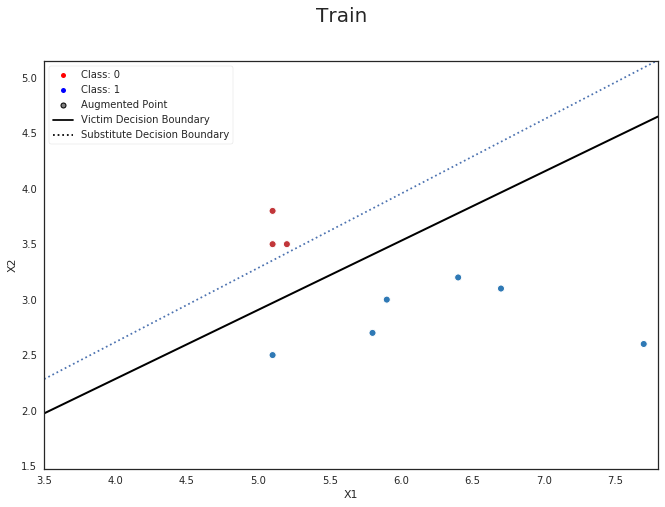

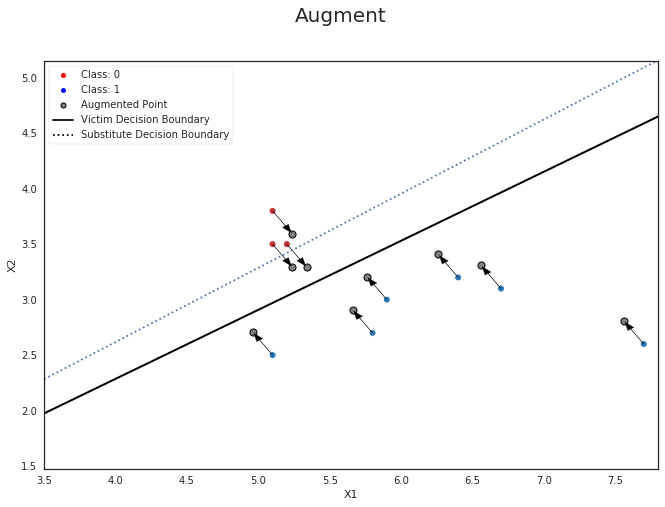

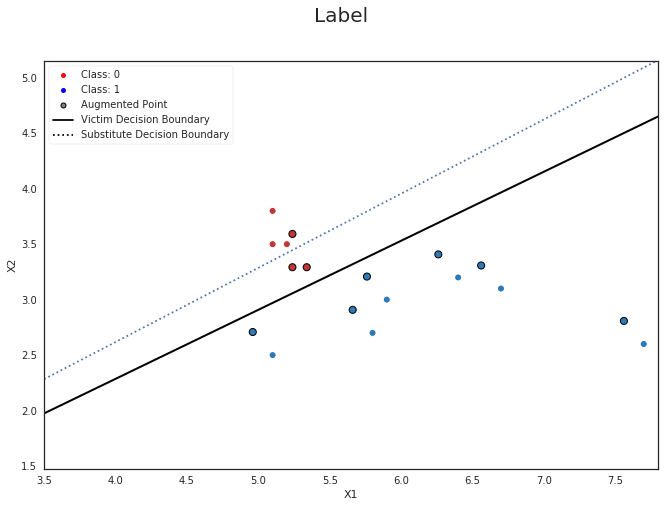

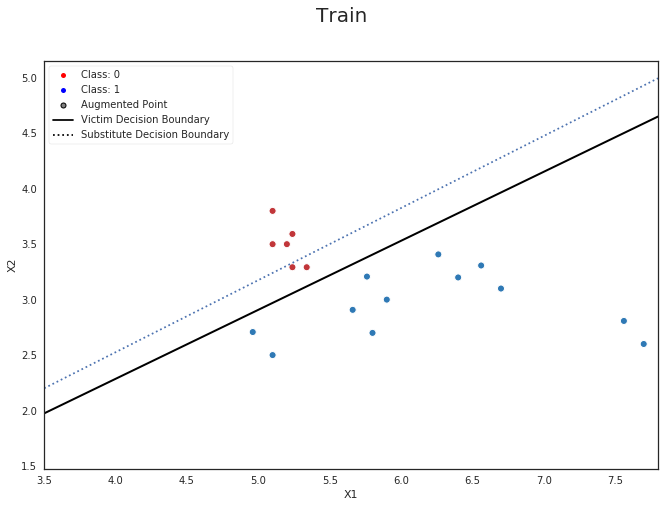

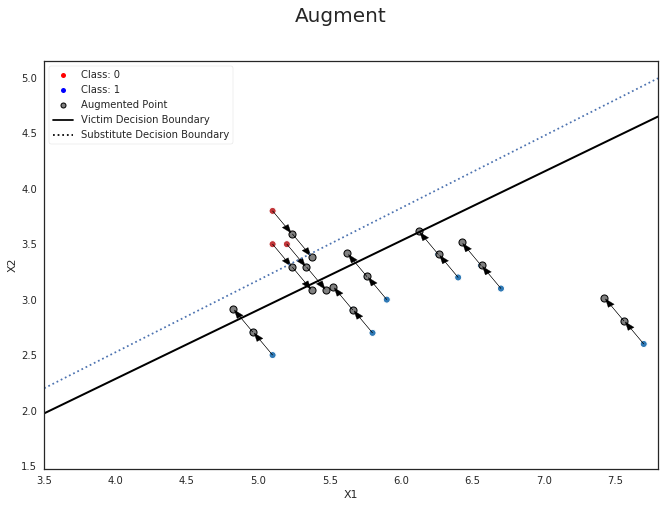

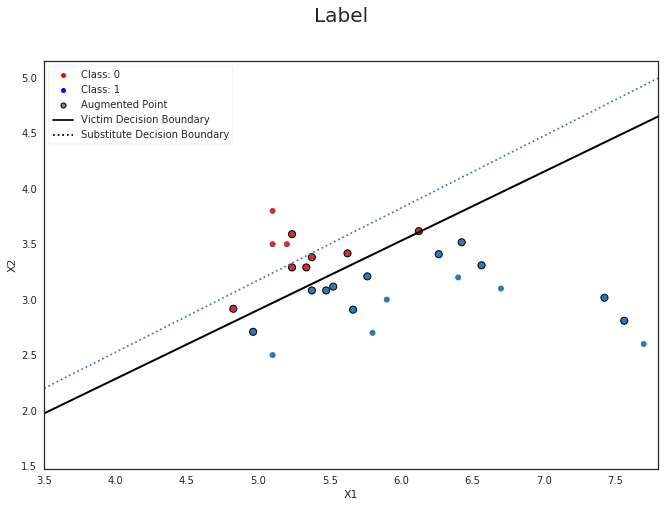

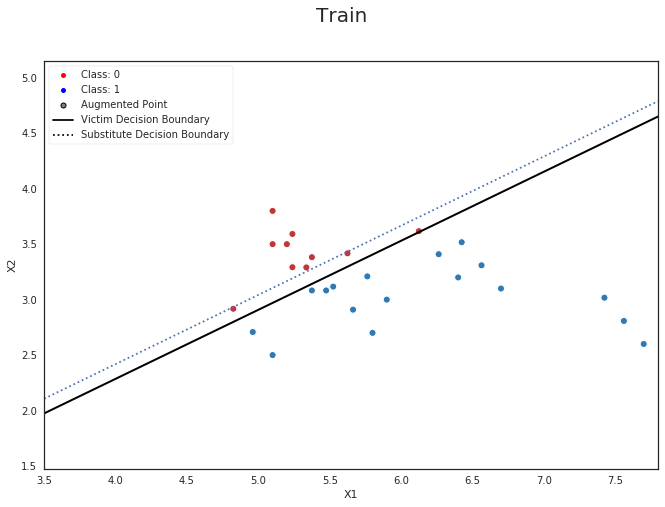

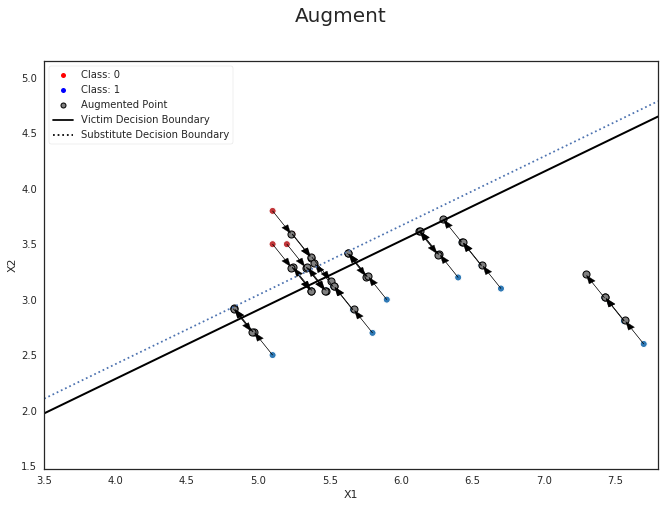

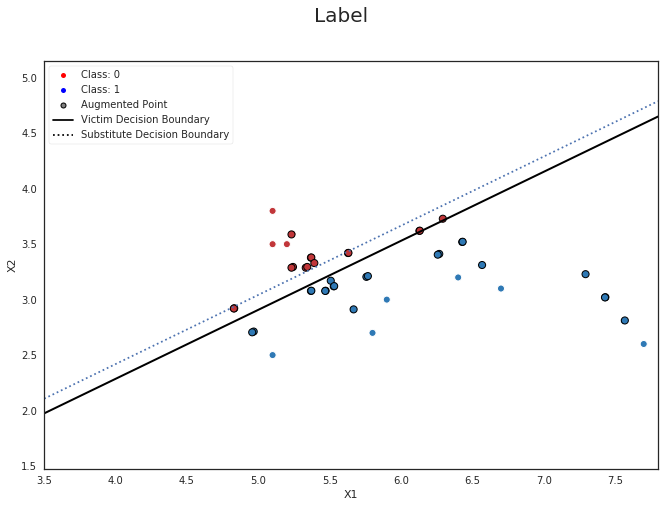

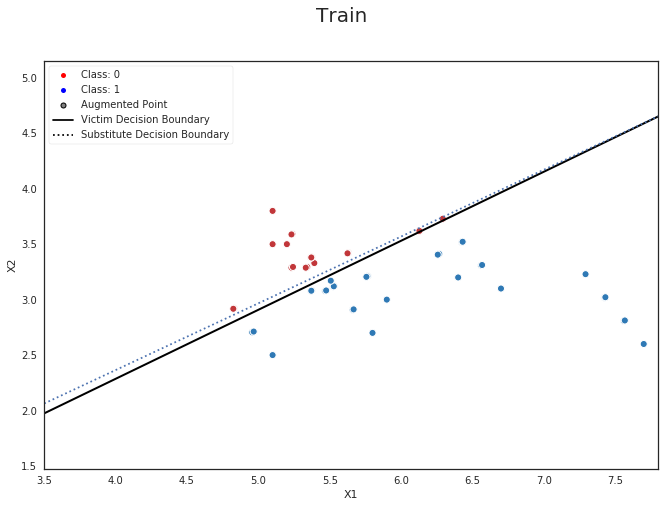

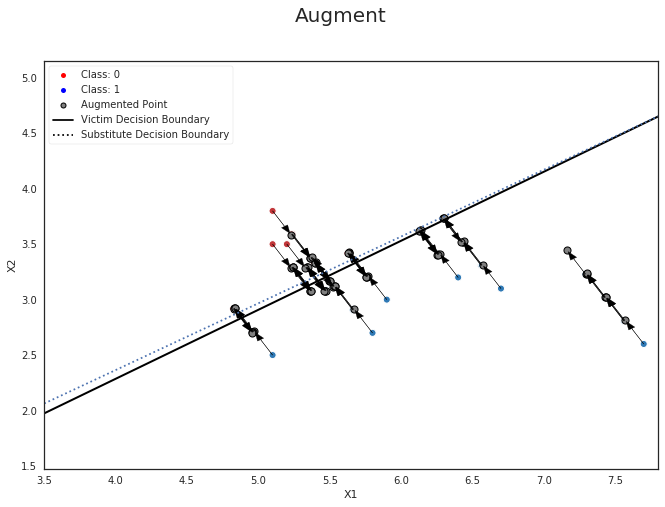

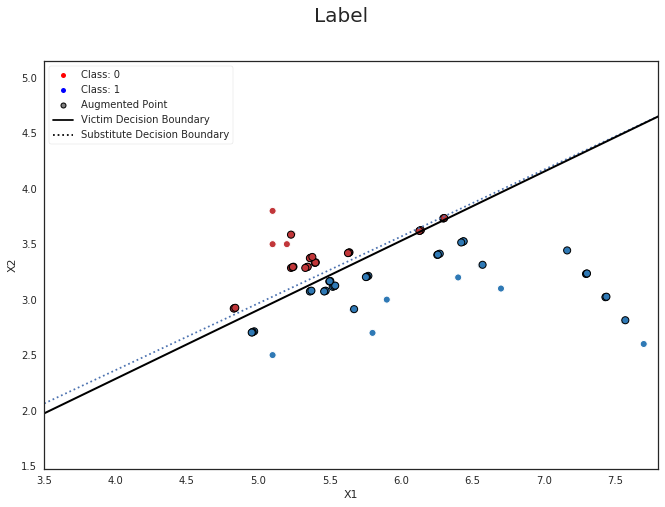

In [179]:
sub_model.train(augment_count = 5, lambda_ = 0.25)

In [137]:
x_t = X[balanced_sample,]
y_t = clf.predict(x_t)

In [148]:
sub = LogisticRegression().fit(x_t,y_t)

In [149]:
(xx_sub, yy_sub) = decision_boundary(sub,(0,10))
(xx_mod, yy_mod) = decision_boundary(clf, (0,10))

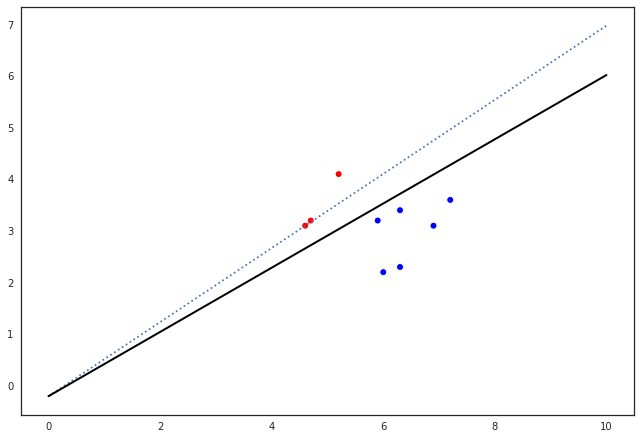

In [152]:
colors = np.asarray(["r"]*len(y_t))
colors[y_t==1] = "b"
f, ax = plt.subplots(figsize=(figure_size[0], figure_size[1]))
ax.scatter(x_t[:,0], x_t[:, 1], c=colors,edgecolor="white", linewidth=1)
ax.plot(xx_sub, yy_sub, ':')
ax.plot(xx_mod, yy_mod, 'k-', lw = 2)